## Architecture Docker

Comme nous le savons déjà, Docker utilise le concept de construction unique, exécuté n'importe où. Docker regroupe les applications en images. 

Les images Docker forment le plan des conteneurs, donc un conteneur est une instance d'une image. Une image de conteneur regroupe les applications et leurs dépendances, de sorte qu'elles constituent une seule unité modifiable que vous pouvez exécuter sur n'importe quelle machine exécutant Docker. 

Vous pouvez également les visualiser comme un instantané du conteneur. Nous pouvons créer et stocker des images Docker dans un registre Docker tel que Docker Hub, puis télécharger et utiliser ces images dans le système où nous souhaitons les déployer. Les images comprennent plusieurs couches, il est donc utile de diviser les images en plusieurs parties. 

Les couches ont tendance à être des étapes réutilisables sur lesquelles d'autres images peuvent s'appuyer. Cela signifie également que nous n'avons pas à transmettre l'intégralité de l'image sur un réseau lorsque nous modifions les images et que nous ne transmettons que le delta, ce qui économise beaucoup d'E/S réseau. Nous parlerons du système de fichiers en couches en détail plus loin dans ce guide. 

Le diagramme suivant montre les composants que Docker utilise pour orchestrer les activités suivantes


* Démon Docker : ce processus s'exécute sur les serveurs sur lesquels nous souhaitons exécuter nos conteneurs. Ils déploient et exécutent des conteneurs sur le serveur Docker.
* Docker registries : ils stockent et distribuent des images Docker.
* Client Docker : il s'agit de l'utilitaire de ligne de commande que nous avons utilisé pour envoyer des commandes docker au démon Docker :


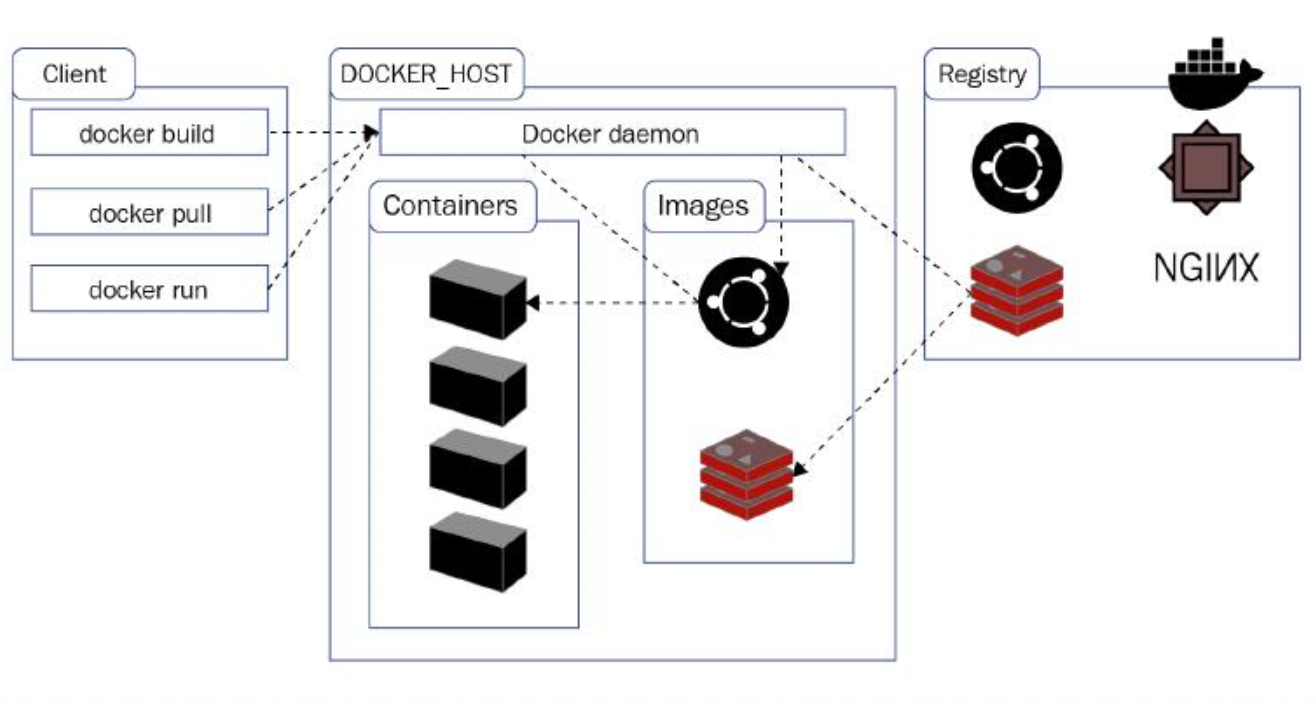

Maintenant que nous comprenons les composants clés de l'architecture Docker et comment les images Docker jouent un rôle essentiel, comprenons en détail les images Docker et leurs composants, directives et registres

## Comprendre les images Docker

Les images Docker constituent le modèle des conteneurs Docker. Tout comme vous avez besoin d'un plan pour un conteneur d'expédition, comme sa taille et les marchandises qu'il contiendra, une image Docker spécifie les packages, le code source, les dépendances et les bibliothèques qu'elle doit utiliser. 

Il détermine également ce qu'il doit faire pour que le code source s'exécute efficacement. Techniquement, il se compose d'une série d'étapes que vous effectueriez sur une image du système d'exploitation de base pour que votre application soit opérationnelle. 

Cela peut inclure l'installation de packages et de dépendances, la copie du code source dans le bon dossier, la création de votre code pour générer un binaire, etc. Vous pouvez stocker des images Docker dans un registre de conteneurs, un emplacement centralisé où vos machines Docker peuvent extraire des images from pour créer des conteneurs. 

Les images Docker utilisent un système de fichiers en couches. Au lieu d'un énorme bloc monolithique sur le système de fichiers qui comprend le modèle pour exécuter les conteneurs, nous avons plusieurs couches, les unes sur les autres

## Comprendre les fichiers Dockerles composants et les directives 

Un fichier Docker est un fichier simple qui constitue une série d'étapes nécessaires pour créer une image Docker. Chaque étape est connue sous le nom de directive, et il existe différents types de directives. 

Regardons un exemple simple pour comprendre comment cela fonctionne. Nous allons créer un simple conteneur NGINX, mais cette fois en construisant l'image à partir de zéro et en n'utilisant pas celle disponible sur Docker Hub. Alors, commencez par créer un Dockerfile, comme suit :



      $ vim Dockerfile
      FROM ubuntu:xenial
      RUN apt update && apt install -y curl
      RUN apt update && apt install -y nginx
      CMD ["nginx", "-g", "daemon off;"]

Examinons chaque ligne et directive une par une pour comprendre comment fonctionne ce Dockerfile :

* La directive FROM spécifie quelle doit être l'image de base de ce conteneur. Cela signifie que nous utilisons une autre image comme base et que nous allons construire des calques dessus. Nous commençons par utiliser le package ubuntu:xenial comme image de base pour cette version, car nous voulons exécuter NGINX sur Ubuntu.

* Les directives RUN spécifient les commandes que nous devons exécuter sur une couche particulière. Vous pouvez exécuter une ou plusieurs commandes séparées par &&. Nous voudrons exécuter plusieurs commandes sur une seule ligne si nous allons regrouper les commandes dépendantes dans une seule couche. Chaque couche doit répondre à un objectif particulier. Dans l'exemple précédent, la première directive RUN est utilisée pour installer curl, tandis que la directive RUN suivante est utilisée pour installer nginx. 
* Vous vous demandez peut-être pourquoi nous avons une mise à jour appropriée avant chaque installation. Cela est requis car Docker crée des images à l'aide de calques. Ainsi, une couche ne doit pas avoir de dépendances implicites avec la précédente. Dans cet exemple, si nous omettons apt update lors de l'installation de nginx, et si nous voulons mettre à jour la version de nginx sans rien changer dans la directive contenant apt update (c'est-à-dire la ligne qui installe curl), lorsque nous exécutons le build, apt update ne s'exécutera plus, donc votre installation de nginx peut échouer

*  La directive CMD spécifie une liste de commandes que nous devons exécuter lorsque l'image construite s'exécute en tant que conteneur. Il s'agit de la commande par défaut qui sera exécutée et sa sortie se retrouvera dans les journaux du conteneur. Votre conteneur peut contenir une ou plusieurs directives CMD. Pour un processus de longue durée tel que NGINX, le dernier CMD doit contenir quelque chose qui ne transmettra pas le contrôle au shell et continuera à s'exécuter pendant toute la durée de vie du conteneur. Dans ce cas, nous exécutons le démon nginx -g off;, qui est un moyen standard d'exécuter NGINX au premier plan


Certaines directives peuvent facilement être confondues, comme l'utilisation de ENTRYPOINT au lieu de CMD ou l'utilisation de CMD au lieu de RUN. Ces questions testent également la solidité de vos fondamentaux Docker, alors examinons les deux.

## Pouvons-nous utiliser ENTRYPOINT au lieu de CMD ? 

Au lieu de CMD, vous pouvez également utiliser ENTRYPOINT. Bien qu'elles servent un objectif similaire, il existe une différence, et ce sont deux directives très différentes. Chaque conteneur Docker a un ENTRYPOINT par défaut – /bin/sh -c. Tout ce que vous ajoutez à CMD est ajouté après ENTRYPOINT et exécuté ; par exemple, CMD ["nginx", "-g", "daemon off;"] sera généré sous la forme /bin/sh -c nginx -g daemon off;. Désormais, si vous utilisez un ENTRYPOINT personnalisé à la place, les commandes que vous utilisez lors du lancement du conteneur seront ajoutées après celui-ci. Donc, si vous définissez ENTRYPOINT ["nginx", "-g"] et utilisez docker run nginx daemon off;, vous obtiendrez un résultat similaire


Pour obtenir un comportement similaire sans ajouter d'arguments CMD lors du lancement du conteneur, vous pouvez également utiliser ENTRYPOINT ["nginx", "-g", "daemon off;"].

## RUN et CMD sont-ils identiques ? 

Non, RUN et CMD sont différents et servent des objectifs différents. Alors que RUN est utilisé pour construire le conteneur et ne modifie que le système de fichiers lors de sa construction, les commandes CMD ne sont exécutées que sur la couche de conteneur accessible en écriture, une fois que le conteneur est en cours d'exécution. Bien qu'il puisse y avoir plusieurs instructions RUN dans un Dockerfile, chacune modifiant la couche existante et générant la suivante, si un Dockerfile contient plus d'une commande CMD, toutes sauf la dernière sont ignorées


Les directives RUN sont utilisées pour exécuter des instructions dans le système de fichiers du conteneur pour construire et personnaliser l'image du conteneur, modifiant ainsi les couches d'image. L'idée d'utiliser une commande CMD est de fournir la ou les commandes par défaut avec l'image du conteneur qui sera exécutée lors de l'exécution. Cela ne modifie que le système de fichiers du conteneur accessible en écriture. Vous pouvez également remplacer les commandes en passant une commande personnalisée dans l'instruction d'exécution du docker. Maintenant, allons de l'avant et construisons notre première image de conteneur

## Construire notre premier conteneur

Construire une image de conteneur est très simple. Il s'agit en fait d'une commande d'une ligne – docker build -t <image-name>:version <build_context>. Alors que nous discuterons de la création d'images de conteneurs en détail dans la section Création et gestion d'images de conteneurs, construisons le 

  
    docker build -t <your_dockerhub_user>/nginx-hello-world .


Vous avez peut-être remarqué que le nom du conteneur était précédé d'un préfixe. Il s'agit du nom de votre compte Docker Hub. Le nom de l'image a une structure de <registry-url>/<account-name>/<container-image-name>:<version>.Ici, nous avons ce qui suit :

* registre-url : l'URL vers le registre Docker – par défaut sur docker.io
* account-name : l'utilisateur ou le compte qui possède l'image
* container-image-name : le nom de l'image du conteneur
* version : l'image version


Créons maintenant un conteneur à partir de l'image à l'aide de la commande suivante :


    docker run -d -p 80:80 <your_dockerhub_user>\/nginx-hello-world

 
Si nous exécutons curl localhost, nous pouvons obtenir la réponse html nginx par défaut, comme suit :

    $ curl localhost
    <!DOCTYPE html>
    <html>
    <head>
    <title>Bienvenue sur nginx !</ title>
    ...
    </body>
    </html>
    
C'est super ! Nous avons construit notre première image à l'aide d'un Dockerfile. Et si nous voulions personnaliser l'image selon nos besoins ? En pratique, personne ne voudrait qu'un conteneur NGINX réponde simplement avec la valeur par défaut Bienvenue sur nginx ! message, créons donc une page d'index et utilisons-la à la place :

    $ vim index.html
    Hello World! This is my first docker image!

Celle-ci génère un message personnalisé au lieu de la page HTML NGINX par défaut. Nous savons tous que le répertoire NGINX par défaut contenant le fichier index.html est /var/www/html. 

Si nous pouvons copier le fichier index.html dans ce répertoire, cela devrait résoudre notre problème. 

Modifiez donc le fichier Docker pour qu'il inclue les éléments suivants :


    $ vim Dockerfile
    FROM ubuntu:xenial
    RUN apt update && apt install -y curl
    RUN apt update && apt install -y nginx
    WORKDIR /var/www/html/
    ADD index.html ./
    CMD ["nginx", "-g", "daemon off;"]


Ici, nous avons ajouté deux directives au fichier – WORKDIR et ADD. Comprenons ce que chacun fait :

* WORKDIR : is définit le répertoire de travail courant, qui est /var/www/html dans ce cas. Le dernier WORKDIR du Dockerfile spécifie également le répertoire de travail lorsque le conteneur est exécuté. Ainsi, si vous exécutez dans un conteneur en cours d'exécution, vous atterrirez dans le dernier WORKDIR défini. Les WORKDIR peuvent être aussi bien absolus que relatifs au répertoire de travail courant.

* add : cela ajoute un fichier local au système de fichiers conteneur – le répertoire de travail, dans ce cas. Vous pouvez également utiliser une directive COPY ici au lieu d'ADD, bien qu'ADD offre quelques fonctionnalités supplémentaires, telles que le téléchargement de fichiers à partir d'une URL et l'utilisation d'une archive telle qu'un package TAR ou ZIP.


Lorsque nous construisons ce fichier, nous nous attendons à ce que le fichier index.html soit copié dans le répertoire /var/www/html du système de fichiers conteneur. Regardons:


    docker build -t <your_dockerhub_user>/nginx-hello-world .

C'est le moment, la construction a été beaucoup plus rapide ! Lorsque nous avons exécuté le build Docker, il a utilisé beaucoup de couches du cache. C'est l'un des avantages d'une architecture en couches - vous ne construisez que la partie qui change et utilisez l'existant tel qu'il est.

Redémarrons le conteneur et voyons ce que nous obtenons. Notez que vous devez supprimer l'ancien conteneur avant de le faire :



    $ docker ps

À ce stade, nous ne pouvons plus voir le conteneur. Maintenant, réexécutons le conteneur à l'aide de la commande suivante :


    docker run -d -p 80:80 <your_dockerhub_user>\/nginx-hello-world



Ici, nous pouvons voir que le conteneur est opérationnel. Utilisons curl localhost pour voir ce que nous obtenons :


    $ curl localhost

Ici, nous obtenons le message personnalisé au lieu de la réponse HTML NGINX par défaut ! 

Cela semble assez bon pour le moment, mais je vais discuter de quelques directives supplémentaires pour rendre cette image plus fiable. Premièrement, nous n'avons pas explicitement documenté quel port ce conteneur doit exposer. Cela fonctionne parfaitement car nous savons que NGINX fonctionne sur le port 80, mais que se passe-t-il si quelqu'un veut utiliser votre image et ne connaît pas le port ? Eh bien, dans ce scénario, il est recommandé de définir explicitement le port. Nous utiliserons la directive EXPOSE pour cela.


Nous devons également définir l'action au processus de conteneur si quelqu'un envoie une commande docker stop. Alors que la plupart des processus prennent l'indice et tuent le processus, il est logique de spécifier explicitement quel STOPSIGNAL le conteneur doit envoyer sur une commande docker stop. Nous utiliserons la directive STOPSIGNAL pour cela.



Maintenant, alors que Docker surveille le processus de conteneur et le maintient en cours d'exécution à moins qu'il ne reçoive un SIGTERM ou un arrêt, que se passerait-il si votre processus de conteneur se bloque pour une raison quelconque ? Ainsi, alors que votre application est bloquée, Docker pense toujours qu'elle est en cours d'exécution car votre processus est toujours en cours d'exécution. Par conséquent, il serait judicieux de surveiller l'application via un contrôle de santé explicite. Nous utiliserons la directive HEALTHCHECK pour cela. Combinons tous ces aspects et voyons ce que nous obtenons dans le Dockerfile :



    $ vim Dockerfile
    FROM ubuntu:xenial
    RUN apt update && apt install -y curl
    RUN apt update && apt install -y nginx
    WORKDIR /var/www/html/
    ADD index.html ./
    EXPOSE 80
    CMD ["nginx", "-g", "daemon off;"]
    STOPSIGNAL SIGTERM
    HEALTHCHECK --interval=60s --timeout=10s --start-period=20s --retries=3 CMD curl -f localhost



Alors que EXPOSE et STOPSIGNAL sont explicites, regardons la directive HEALTHCHECK. Ainsi, la directive HEALTHCHECK exécute une commande (d'où CMD) appelée curl -f localhost. Ainsi, ce conteneur se signalera comme sain jusqu'à ce que le résultat de la commande curl soit un succès. La directive HEALTHCHECK contient également les champs facultatifs suivants :

* --interval (par défaut : 30s) : l'intervalle de temps entre deux vérifications d'état ultérieures.
* --timeout (par défaut : 30s) : l'intervalle de délai d'expiration de la sonde de vérification d'état. Si la vérification de l'état expire, cela implique un échec de la vérification de l'état.

* --start-period (par défaut : 0s) : le délai entre le démarrage du conteneur et le premier bilan de santé. Cela vous permet de vous assurer que votre conteneur est opérationnel avant qu'un contrôle de santé ne soit effectué.
* --retries (par défaut : 3) : le nombre de fois que la sonde réessayera avant de déclarer un état défectueux


Maintenant, construisons ce conteneur :


    $ docker build -t <your_dockerhub_user>/nginx-hello-world .


    $ docker run -d -p 80:80 <your_dockerhub_user>\/nginx-hello-world



Maintenant que nous avons lancé le conteneur avec succès, essayons ps et voyons ce que nous obtenons :


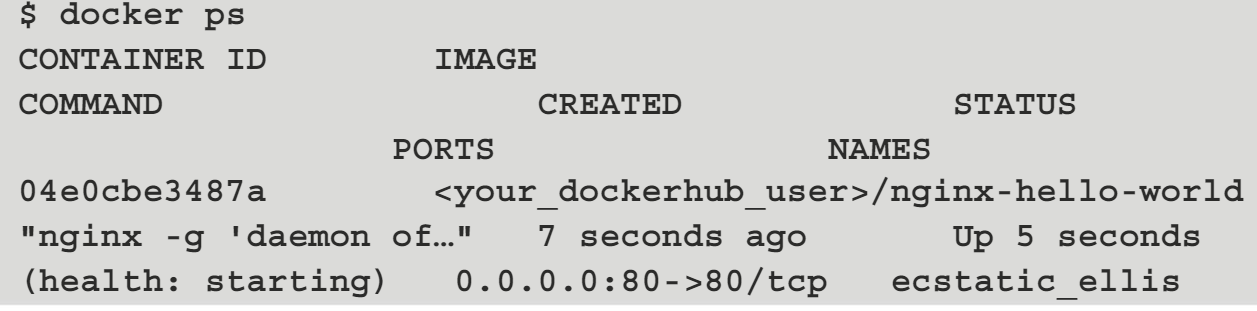


Ainsi, comme nous pouvons le voir, le conteneur affiche l'état de santé : démarrage, ce qui signifie que la vérification de l'état n'a pas encore été lancée et que nous attendons l'expiration de l'heure de début.

Attendons un moment et refaites un docker ps :


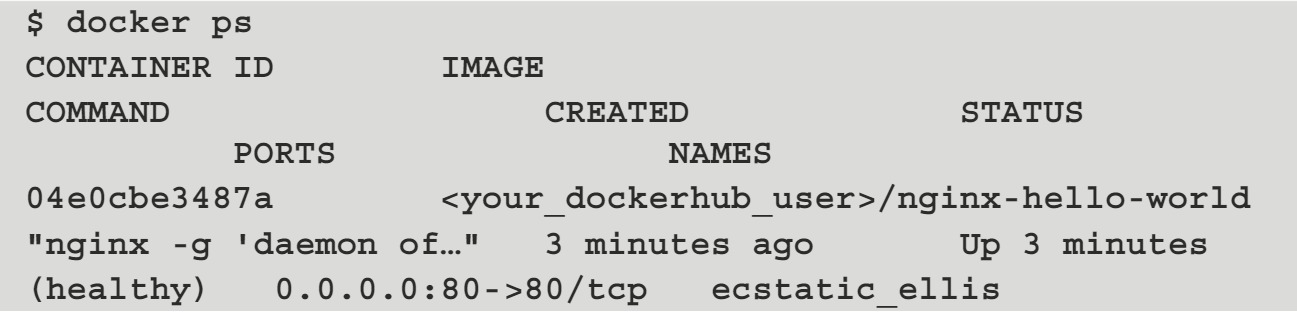

Cette fois, il signale le conteneur comme sain. Ainsi, notre conteneur est désormais plus fiable, car toute personne qui le surveille saura quelle partie de l'application est saine et quelle partie ne l'est pas. 

Cette vérification de l'état ne rapporte que l'état de santé du conteneur. Il ne prend aucune mesure au-delà de cela. Il est de votre responsabilité de surveiller périodiquement les conteneurs et d'écrire un script qui peut agir sur les conteneurs non sains. 

Une façon de gérer cela serait de créer un script qui recherche les conteneurs non sains et les redémarre. Vous pouvez planifier un tel script dans votre cron. Vous pouvez également créer un script systemd de longue durée qui interroge en permanence les processus du conteneur et vérifie l'état de santé

## Constructions en une seule étape 

Conteneurons une application Go simple qui imprime Hello, World ! sur l'écran. Bien que j'utilise Golang dans cette application, ce concept est applicable universellement, quel que soit le langage de programmation. 

Les fichiers respectifs pour cet exemple sont présents dans le répertoire ch3/go-hello-world/single-stage du référentiel GitHub de ce guide .

Regardons d'abord le fichier de l'application Go, app.go :


    package maini
    mport "fmt"
    func main() {    
      fmt.Println("Hello, World!")
      }

Le Dockerfile se présente comme suit:

    FROM golang:1.12.4
    WORKDIR /tmp
    COPY app.go .
    RUN GOOS=linux go build -a -installsuffix cgo -o app . && chmod +x ./app
    CMD ["./app"]



C'est un truc standard. Nous prenons l'image de base golang:1.12.4, déclarons un WORKDIR /tmp, copions app.go du système de fichiers hôte vers le conteneur et construisons l'application Go pour générer un binaire. Enfin, nous utilisons la directive CMD avec le binaire généré à exécuter lorsque nous exécutons le conteneur.

Construisons le Dockerfile :


      $ docker build -t <your_dockerhub_user>\/go-hello-world:single_stage .

      $ docker run <your_dockerhub_user>/go-hello-world:single_stageHello, World!

      $ docker images


Cette image est énorme ! Il faut 784 Mo juste pour imprimer Hello, World! sur l'écran. Ce n'est pas le moyen le plus eficace de créer des images Docker.



Avant d'examiner la solution, comprenons pourquoi l'image est si gonflée en premier lieu. Nous utilisons l'image de base Golang, qui contient l'intégralité de la boîte à outils Go et génère un binaire simple. Pour que cette application s'exécute, nous n'avons pas besoin de la boîte à outils Go complète, et elle peut s'exécuter eficacement dans une image Alpine Linux. 

Docker résout ce problème en fournissant des builds en plusieurs étapes. Vous pouvez diviser votre construction en étapes où vous pouvez construire votre code en une étape, puis, dans la deuxième étape, exporter le code construit vers un autre contexte qui commence par une image de base différente qui est beaucoup plus légère et ne contient que celles-ci fichiers et composants dont nous avons besoin pour exécuter le code. Nous verrons cela dans la section suivante.



## Constructions en plusieurs étapes 

Maintenant, modifions le fichier Docker en fonction du processus de construction en plusieurs étapes et voyons ce que nous obtenons. 

Les fichiers respectifs pour cet exemple sont présents dans le répertoire ch3/go-hello-world/multi-stage dans le référentiel GitHub de ce guide. Voici le Dockerfile :


    FROM golang:1.12.4 AS build
    WORKDIR /tmp
    COPY app.go .
    RUN GOOS=linux go build -a -installsuffix cgo -o app . && chmod +x ./app

    FROM alpine:3.12.1
    WORKDIR /tmp
    COPY --from=build /tmp/app .
    CMD ["./app"]


Le fichier Docker contient deux directives FROM – FROM golang:1.12.4 AS build et FROM alpine:3.12.1. La première directive FROM inclut également une directive AS qui déclare la scène et nomme sa construction. 

Tout ce que nous faisons après cette directive FROM est accessible en utilisant le terme de build jusqu'à ce que nous rencontrions une autre directive FROM, qui constituerait la deuxième étape. Étant donné que la deuxième étape est celle à partir de laquelle nous voulons exécuter notre image, nous n'utilisons pas de directive AS. Dans la première étape, nous construisons notre code Golang pour générer le binaire, nous utilisons donc l'image de base golang.



Dans la deuxième étape, nous utilisons l'image de base alpine et copions le fichier /tmp/app de l'étape de construction dans notre étape actuelle. C'est le seul fichier que nous devons exécuter dans le conteneur. Le reste du matériel était juste requis pour la construction et gonflait notre conteneur pendant l'exécution. Construisons l'image et voyons ce que nous obtenons :


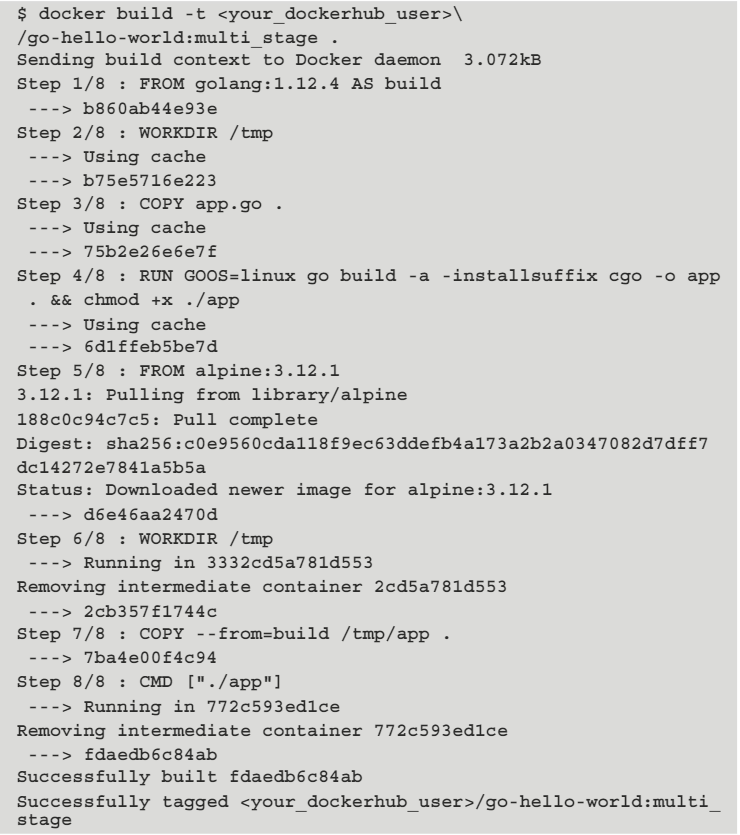

Maintenant, exécutons le conteneur 

    docker run <your_dockerhub_user>/go-hello-world:multi_stageHello, World!


Nous obtenons le même résultat, mais cette fois avec un encombrement minimal. Regardons l'image pour confirmer cela


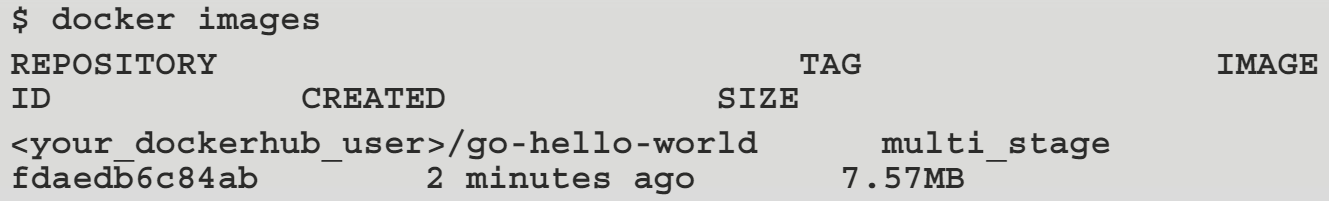

Celui-ci n'occupe que 7,57 Mo au lieu des 784 Mo énormes. C'est une énorme amélioration ! Nous avons réduit la taille de l'image 100 fois. C'est ainsi que nous renforçons l'eficacité de notre image de conteneur. La création d'images eficaces est la clé de l'exécution de conteneurs prêts pour la production, et la plupart des images professionnelles que vous trouverez sur Docker Hub utilisent des builds en plusieurs étapes pour créer des images eficaces.




Dans la section suivante, nous examinerons la gestion des images dans Docker, quelques bonnes pratiques et certaines des commandes les plus fréquemment utilisées

## Gestion des images Docker

Dans les pratiques DevOps modernes, les images Docker sont principalement construites soit dans une machine de développeur, soit dans un pipeline CI/CD. 

Les images sont stockées dans un registre de conteneurs, puis déployées dans plusieurs environnements de transfert et machines de production. Ils peuvent exécuter Docker ou un orchestrateur de conteneurs tel que Kubernetes par-dessus. 

Pour utiliser eficacement les images, nous devons comprendre comment nous pouvons les baliser. Principalement, Docker extrait l'image une fois lorsque vous exécutez un docker. 

Cela signifie qu'une fois qu'une image avec une version particulière est présente sur la machine, Docker n'essaiera pas de l'extraire à chaque exécution à moins que vous ne l'étiez explicitement.


Pour extraire explicitement l'image, vous pouvez utiliser la commande docker pull, comme suit :



    $ docker pull nginx

Maintenant, si nous essayons de lancer un conteneur à l'aide de cette image, il lancera instantanément le conteneur sans extraire l'image, comme suit :


    $ docker run nginx

C'est donc une mauvaise idée d'utiliser la dernière balise sur une image, et une bonne pratique consiste à utiliser des versions sémantiques comme balise. Il y a deux raisons principales à cela : 

* Si vous construisez la dernière image à chaque fois, les orchestrateurs tels que Docker Compose et Kubernetes supposeront que l'image est déjà présente sur votre machine et ne tirera pas votre image par défaut. Si vous utilisez une stratégie d'extraction d'image telle que Always on Kubernetes ou utilisez un script pour extraire l'image, c'est un gaspillage de bande passante réseau. Il est également important de noter que Docker limite le nombre de tirages que vous pouvez effectuer sur des images open source, vous devez donc vous assurer de limiter vos tirages uniquement lorsque cela est nécessaire. 


* Les balises Docker vous permettent de déployer ou de restaurer rapidement votre déploiement de conteneurs. Si vous utilisez toujours la dernière balise, la nouvelle version remplace l'ancienne, il n'y a donc aucun moyen de restaurer un conteneur défectueux vers la dernière bonne version connue. 
C'est aussi une bonne idée d'utiliser des images versionnées en production pour assurer la stabilité de votre conteneur. Si, pour une raison quelconque, vous perdez l'image locale et décidez de réexécuter votre conteneur, vous risquez de ne pas obtenir la même version du logiciel que vous exécutiez déjà car la dernière balise change fréquemment. Il est donc préférable d'utiliser une version particulière du conteneur en production pour plus de stabilité.


les mages sont composés de plusieurs couches et la plupart du temps, il existe une relation entre différentes versions de conteneurs qui s'exécutent sur votre serveur. Avec le temps et avec le déploiement de nouvelles versions d'images dans votre environnement de production, il est préférable de supprimer les anciennes images par le biais d'un entretien. Cela récupérera de l'espace précieux que les images de conteneur occupaient et produira un système de fichiers plus propre. 

Pour supprimer une image particulière, vous pouvez utiliser la commande docker rmi, comme suit :



    $ docker rmi nginx
    Error response from daemon: conflict: unable to remove repository reference
    "nginx" (must force) - container dfb0f297237c is using its referenced image
    bc9a0695f571


Oh! Nous obtenons une erreur, mais pourquoi ? Eh bien, c'est parce que nous avons un conteneur qui s'exécute et utilise cette image.



      Conseil
      Vous ne pouvez pas supprimer les images actuellement utilisées par un
      conteneur en cours d'exécution.


Tout d'abord, vous devrez arrêter et retirer le conteneur. Ensuite, vous pouvez continuer et supprimer l'image à l'aide de la commande précédente. Si vous voulez tout faire en même temps, vous pouvez forcer la suppression en utilisant l'indicateur -f, qui arrêtera le conteneur, le supprimera, puis supprimera l'image. Donc, à moins que vous ne sachiez ce que vous faites, n'utilisez pas l'indicateur -f :


    $ docker rmi -f nginx


Nous avons construit notre conteneur plusieurs fois, mais que devons-nous faire si nous devons pousser vers Docker Hub ou d'autres registres ? Mais avant cela, nous devrons nous authentifier auprès de Docker Hub à l'aide de la commande suivante :



    $ docker login


Maintenant, vous pouvez envoyer l'image vers Docker Hub à l'aide de la commande suivante :


    $ docker push <your_dockerhub_user>/nginx-hello-world:latest


Cela a poussé trois couches et monté le reste à partir d'Ubuntu. C'est parce que nous avons utilisé Ubuntu comme image de base, qui était déjà disponible sur Docker Hub.

Si vous avez plusieurs balises pour l'image et que vous souhaitez toutes les pousser, vous pouvez simplement omettre la balise dans la commande push ; cela poussera toutes les balises pour cette image particulière, comme suit :


    $ docker push <your_dockerhub_user>/go-hello-world


## Hébergement de votre registre Docker privé

Docker fournit une image que vous pouvez exécuter sur n'importe quel serveur sur lequel Docker est installé. Une fois le conteneur opérationnel, vous pouvez simplement l'utiliser comme registre Docker. Regardons:



    docker run -d -p 80:5000 --restart=always --name registry \registry:2


Puisque nous savons que le registre s'exécute sur localhost et écoute sur le port 80, essayons de pousser une image vers ce registre. Commençons par baliser l'image pour spécifier localhost comme registre. Nous ajouterons un emplacement de registre au début de la balise Docker afin que Docker sache où pousser l'image. Nous savons déjà que la structure d'une balise Docker est <registry_url>/<user>/<image_name>:<image_version>. Nous utiliserons la commande docker tag pour donner un autre nom à une image existante, comme indiqué dans la commande suivante :




    docker tag <your_dockerhub_user>/nginx-hello-world:latest \localhost/<your_dockerhub_user>/nginx-hello-world:latest




Maintenant, nous pouvons continuer et envoyer l'image au registre Docker local :


    $ docker push localhost/<your_dockerhub_user>/\nginx-hello-world:latest


Et c'est tout! C'est aussi simple que cela ! 

Il y a d'autres considérations aussi, car c'est trop simpliste. Vous devrez également monter des volumes ; sinon, vous perdrez toutes les images lorsque vous redémarrerez le conteneur de registre. De plus, aucune authentification n'est en place, donc toute personne pouvant accéder à ce serveur peut envoyer ou extraire des images, mais c'est quelque chose que nous ne souhaitons pas. De plus, la communication n'est pas sécurisée et nous souhaitons chiffrer les images pendant le transit. Tout d'abord, créons les répertoires locaux que nous monterons sur les conteneurs :


    mkdir -p /mnt/registry/certs
    mkdir -p /mnt/registry/auth


Maintenant, générons un fichier htpasswd pour ajouter l'authentification au registre. Pour cela, nous exécuterons la commande htpasswd depuis un nouveau conteneur Docker Registry pour créer un fichier sur notre répertoire local :



    $ docker run --entrypoint htpasswd registry:2.7.0 \-Bbn user pass > /mnt/registry/auth/htpasswd


L'étape suivante consiste à générer des certificats auto-signés pour activer TLS sur le référentiel. Ajoutez votre nom de serveur ou IP lorsqu'on vous demande un nom de domaine entièrement qualié (FQDN). Vous pouvez laisser les autres champs vides ou leur ajouter des valeurs appropriées :



    $ openssl req \
     -newkey rsa:4096 -nodes -sha256 -keyout \
     /mnt/registry/certs/domain.key \ 
     -x509 -days 365 -out /mnt/registry/certs/domain.crt



Avant de continuer, supprimons le registre existant :


      $ docker rm -f registry
      registry


Maintenant, nous sommes prêts à lancer notre conteneur avec la configuration requise :



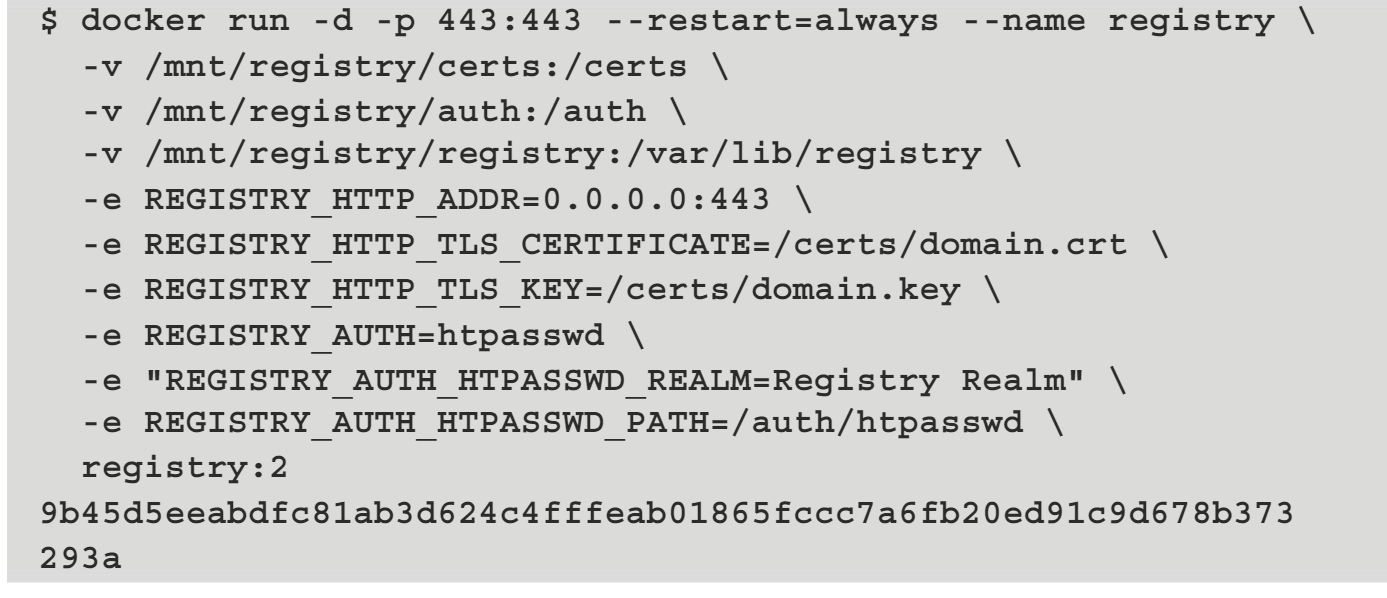

Le conteneur est maintenant opérationnel. Utilisons https cette fois, mais avant cela, connectons Docker au registre. Ajoutez le nom d'utilisateur et le mot de passe que vous avez définis lors de la création du fichier htpasswd (dans ce cas, user et pass) :


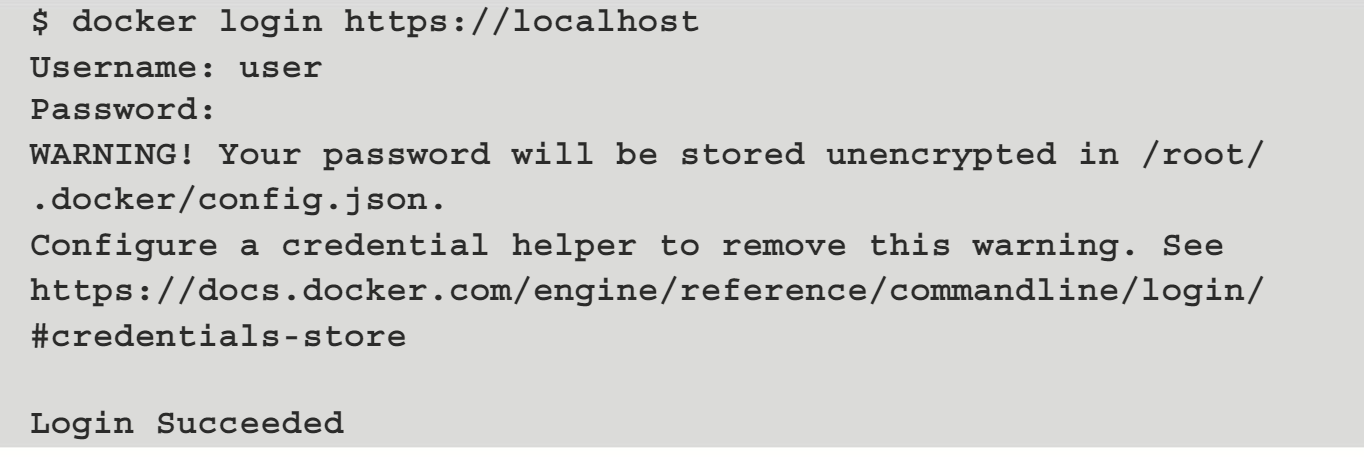

Puisque la connexion a réussi, nous pouvons continuer et envoyer notre image au registre :

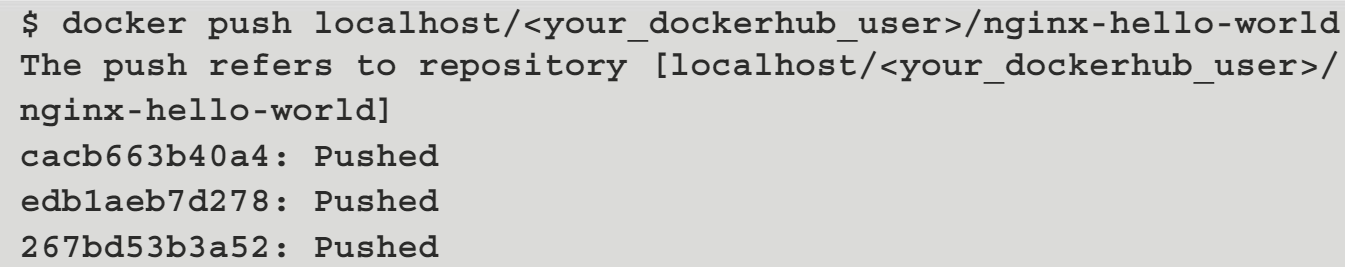